In [123]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import round, mean, min, max, col, floor, avg, explode

In [124]:
spark = SparkSession.builder.appName("Music").getOrCreate()
df = spark.read.csv("output.csv", header=True)

In [125]:
float_columns = ["Popularity", "Acousticness", "Energy", "Instrumentalness", 
                 "Liveness", "Loudness", "Speechiness", "Tempo", "Valence"]

int_columns = ["Mode", "Time Signature"]

In [126]:
for col in float_columns:
    df = df.withColumn(col, df[col].cast(FloatType()))

# Chuyển đổi các cột integer
for col in int_columns:
    df = df.withColumn(col, df[col].cast(IntegerType()))
mean_value = df.select(mean("Popularity")).collect()[0][0]
df = df.fillna({"Popularity": mean_value})

In [127]:
df = df.withColumn("Popularity", round(df["Popularity"]).cast(IntegerType()))
df = df.filter((df["Popularity"] >= 0) & (df["Popularity"] <= 100))

df.printSchema()


root
 |-- Track ID: string (nullable = true)
 |-- Track Name: string (nullable = true)
 |-- Track Number: string (nullable = true)
 |-- Duration (ms): string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album Name: string (nullable = true)
 |-- Artists: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Available Markets: string (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Acousticness: float (nullable = true)
 |-- Energy: float (nullable = true)
 |-- Instrumentalness: float (nullable = true)
 |-- Liveness: float (nullable = true)
 |-- Loudness: float (nullable = true)
 |-- Mode: integer (nullable = true)
 |-- Speechiness: float (nullable = true)
 |-- Tempo: float (nullable = true)
 |-- Time Signature: integer (nullable = true)
 |-- Valence: float (nullable = true)



In [128]:
from pyspark.sql.functions import when
df = df.withColumn("Popularity_Level", 
                   when(df["Popularity"] >= 80, "High")
                   .when(df["Popularity"] >= 50, "Medium")
                   .otherwise("Low"))
df.head(5)

[Row(Track ID='7EhJMeBeptBfJh8kkjZXjw', Track Name='intro (end of the world)', Track Number='1', Duration (ms)='92400', Explicit='True', Album Name='eternal sunshine (slightly deluxe and also live)', Artists="['Ariana Grande']", Genres="['pop']", Available Markets='AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY, CZ, DK, DO, DE, EC, EE, SV, FI, FR, GR, GT, HN, HK, HU, IS, IE, IT, LV, LT, LU, MY, MT, MX, NL, NZ, NI, NO, PA, PY, PE, PH, PL, PT, SG, SK, ES, SE, CH, TW, TR, UY, US, GB, AD, LI, MC, ID, JP, TH, VN, RO, IL, ZA, SA, AE, BH, QA, OM, KW, EG, MA, DZ, TN, LB, JO, PS, IN, KZ, MD, UA, AL, BA, HR, ME, MK, RS, SI, KR, BD, PK, LK, GH, KE, NG, TZ, UG, AG, AM, BS, BB, BZ, BT, BW, BF, CV, CW, DM, FJ, GM, GE, GD, GW, GY, HT, JM, KI, LS, LR, MW, MV, ML, MH, FM, NA, NR, NE, PW, PG, WS, SM, ST, SN, SC, SL, SB, KN, LC, VC, SR, TL, TO, TT, TV, VU, AZ, BN, BI, KH, CM, TD, KM, GQ, SZ, GA, GN, KG, LA, MO, MR, MN, NP, RW, TG, UZ, ZW, BJ, MG, MU, MZ, AO, CI, DJ, ZM, CD, CG, IQ, LY, TJ, VE, ET, XK', P

In [129]:
filtered_df = df.filter(
    (df["Energy"] >= 0) & (df["Energy"] <= 1) &
    (df["Acousticness"] >= 0) & (df["Acousticness"] <= 1) &
    (df["Valence"] >= 0) & (df["Valence"] <= 1)
)

In [130]:
filtered_df.describe(["Popularity", "Acousticness", "Energy", "Liveness", "Tempo", "Valence"]).show()


+-------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+
|summary|        Popularity|       Acousticness|             Energy|           Liveness|            Tempo|           Valence|
+-------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+
|  count|           5283745|            5283745|            5283745|            5283745|          5283745|           5283745|
|   mean|21.740449435012476|0.40876680507822827| 0.5275825918012277|0.22353856617106677|125.4383395334962|0.5594153513495148|
| stddev|31.656380622828173| 0.2851209348450635|0.21561030822773286|0.15666879237370115|22.95550949916689|0.2243927877447581|
|    min|                 0|                0.0|                0.0|       -0.017749248|              0.0|               0.0|
|    max|               100|                1.0|                1.0|                1.0|            244.2|            

In [131]:
filtered_df.groupBy("Genres").count().orderBy("count", ascending=False).show()


+--------------------+------+
|              Genres| count|
+--------------------+------+
|                  []|269986|
|    ['japanese vgm']| 63540|
|           ['sleep']| 28824|
|           ['filmi']| 25962|
|     ['white noise']| 25575|
|['orchestral soun...| 21654|
|         ['chanson']| 15903|
|       ['sillycore']| 14337|
|['norteno', 'musi...| 13815|
|['musica mexicana...| 13326|
|             ['pop']| 13161|
|['calming instrum...| 12654|
|['soundtrack', 'o...| 11913|
|['modern bollywoo...| 11763|
|"[""children's mu...| 10956|
|         ['lullaby']| 10872|
|['pop', 'dance pop']| 10221|
|         ['norteno']|  9987|
|        ['cali rap']|  9916|
|['rockabilly', 'r...|  9567|
+--------------------+------+
only showing top 20 rows



In [132]:
filtered_df.printSchema()

root
 |-- Track ID: string (nullable = true)
 |-- Track Name: string (nullable = true)
 |-- Track Number: string (nullable = true)
 |-- Duration (ms): string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album Name: string (nullable = true)
 |-- Artists: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Available Markets: string (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Acousticness: float (nullable = true)
 |-- Energy: float (nullable = true)
 |-- Instrumentalness: float (nullable = true)
 |-- Liveness: float (nullable = true)
 |-- Loudness: float (nullable = true)
 |-- Mode: integer (nullable = true)
 |-- Speechiness: float (nullable = true)
 |-- Tempo: float (nullable = true)
 |-- Time Signature: integer (nullable = true)
 |-- Valence: float (nullable = true)
 |-- Popularity_Level: string (nullable = false)



In [133]:
filtered_df.groupBy("Artists").count().orderBy("count", ascending=False).show()

+-------------------------------+-----+
|                        Artists|count|
+-------------------------------+-----+
|['アトラスサウンドチーム', '...|20340|
|           ['The Beach Boys'...|17637|
|           ['Louis Armstrong...|17052|
|           ['Ambi Nature', '...|16545|
|           ['La Arrolladora ...|15930|
|           ['Elvis Presley',...|15816|
|           ['Alan Silvestri'...|14979|
|           ['Atmosphere', 'S...|14445|
|            ['Louis Armstrong']|13875|
|           ['Ella Fitzgerald...|13590|
|           ['Neil Diamond', ...|13338|
|           ['Prince', 'Prince']|13035|
|           ['Frank Sinatra',...|12885|
|           ['Baby Sleeps', '...|12759|
|           ['Arcade Player',...|12687|
|           ['Andy Williams',...|12468|
|           ['La Mafia', 'La ...|12429|
|           ['Charles Aznavou...|12267|
|           ['Bob Dylan', 'Bo...|12033|
|           ['Antonio Aguilar...|11967|
+-------------------------------+-----+
only showing top 20 rows



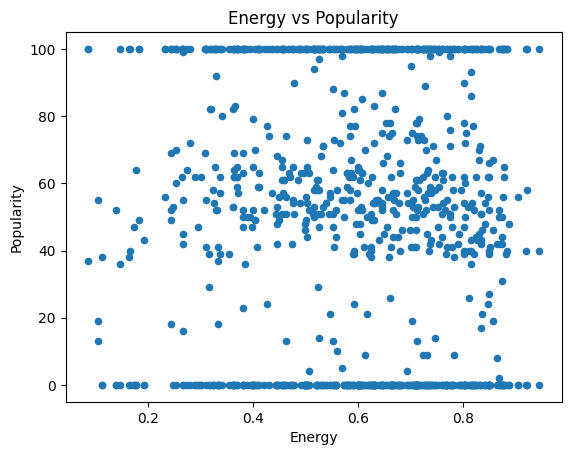

In [134]:
import matplotlib.pyplot as plt
filtered_df.limit(1000).select("Popularity", "Energy").toPandas().plot.scatter(x="Energy", y="Popularity")
plt.title("Energy vs Popularity")
plt.xlabel("Energy")
plt.ylabel("Popularity")
plt.show()


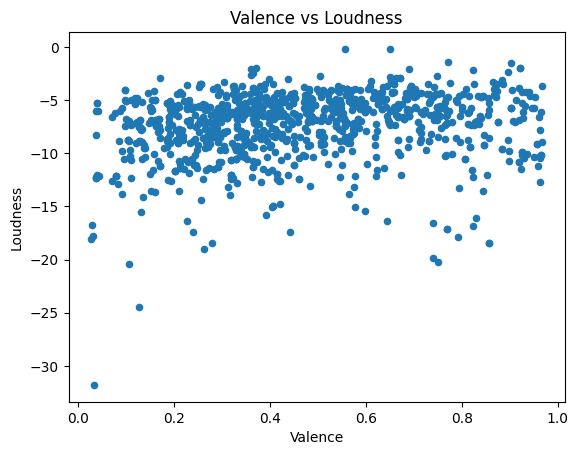

In [135]:

filtered_df.sample(fraction=0.1, seed=42).limit(1000).select("Valence", "Loudness").toPandas().plot.scatter(x="Valence", y="Loudness")

plt.title("Valence vs Loudness")
plt.xlabel("Valence")
plt.ylabel("Loudness")
plt.show()


In [136]:
filtered_df.printSchema()

root
 |-- Track ID: string (nullable = true)
 |-- Track Name: string (nullable = true)
 |-- Track Number: string (nullable = true)
 |-- Duration (ms): string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album Name: string (nullable = true)
 |-- Artists: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Available Markets: string (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Acousticness: float (nullable = true)
 |-- Energy: float (nullable = true)
 |-- Instrumentalness: float (nullable = true)
 |-- Liveness: float (nullable = true)
 |-- Loudness: float (nullable = true)
 |-- Mode: integer (nullable = true)
 |-- Speechiness: float (nullable = true)
 |-- Tempo: float (nullable = true)
 |-- Time Signature: integer (nullable = true)
 |-- Valence: float (nullable = true)
 |-- Popularity_Level: string (nullable = false)



In [137]:
binned_df = filtered_df.withColumn("Energy_Bin", (floor(col("Energy") * 10) / 10))

grouped_df = binned_df.groupBy("Energy_Bin").agg(avg("Popularity").alias("Avg_Popularity"))

# Hiển thị kết quả
grouped_df.orderBy("Energy_Bin").show()

TypeError: 'str' object is not callable

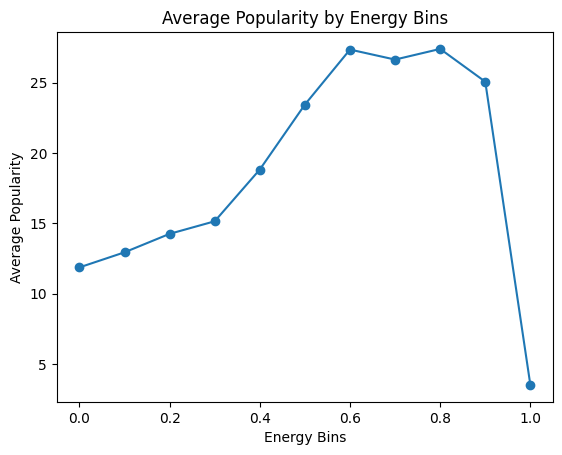

In [ ]:
grouped_pandas_df = grouped_df.orderBy("Energy_Bin").toPandas()

import matplotlib.pyplot as plt

plt.plot(grouped_pandas_df["Energy_Bin"], grouped_pandas_df["Avg_Popularity"], marker="o")
plt.title("Average Popularity by Energy Bins")
plt.xlabel("Energy Bins")
plt.ylabel("Average Popularity")
plt.show()

In [51]:
top_songs = filtered_df.filter(col("Popularity") > 80)
top_songs.show()

+--------------------+--------------------+------------+-------------+--------+--------------------+--------------------+--------------------+--------------------+----------+------------+------+----------------+--------+--------+----+-----------+-------+--------------+-------+----------------+
|            Track ID|          Track Name|Track Number|Duration (ms)|Explicit|          Album Name|             Artists|              Genres|   Available Markets|Popularity|Acousticness|Energy|Instrumentalness|Liveness|Loudness|Mode|Speechiness|  Tempo|Time Signature|Valence|Popularity_Level|
+--------------------+--------------------+------------+-------------+--------+--------------------+--------------------+--------------------+--------------------+----------+------------+------+----------------+--------+--------+----+-----------+-------+--------------+-------+----------------+
|b0876b58-01ee-47a...|intro (end of the...|           1|        92400|    True|eternal sunshine ...|   ['Ariana Gra

In [ ]:
from pyspark.sql.functions import when, col, regexp_replace, split, explode, size
import pandas as pd
# Step 1: Remove null or empty values in Genres
filtered_df = filtered_df.filter((col("Genres").isNotNull()) & (size(col("Genres")) > 0))
df_exploded = filtered_df.withColumn("Genre", explode(col("Genres")))
genre_counts_spark = df_exploded.groupBy("Genre").count().orderBy(col("count").desc())

genre_counts_spark_df = genre_counts_spark.toPandas()
print(genre_counts_spark_df)

                     Genre   count
0                classical  520129
1                     rock  356276
2             classic rock  289571
3          musica mexicana  278994
4                           269986
...                    ...     ...
4159          Cyril Auvity       2
4160          ""Lil Kim"""       1
4161             ""jsan"""       1
4162  "italian romanticism       1
4163   ""Sinéad OConnor"""       1

[4164 rows x 2 columns]


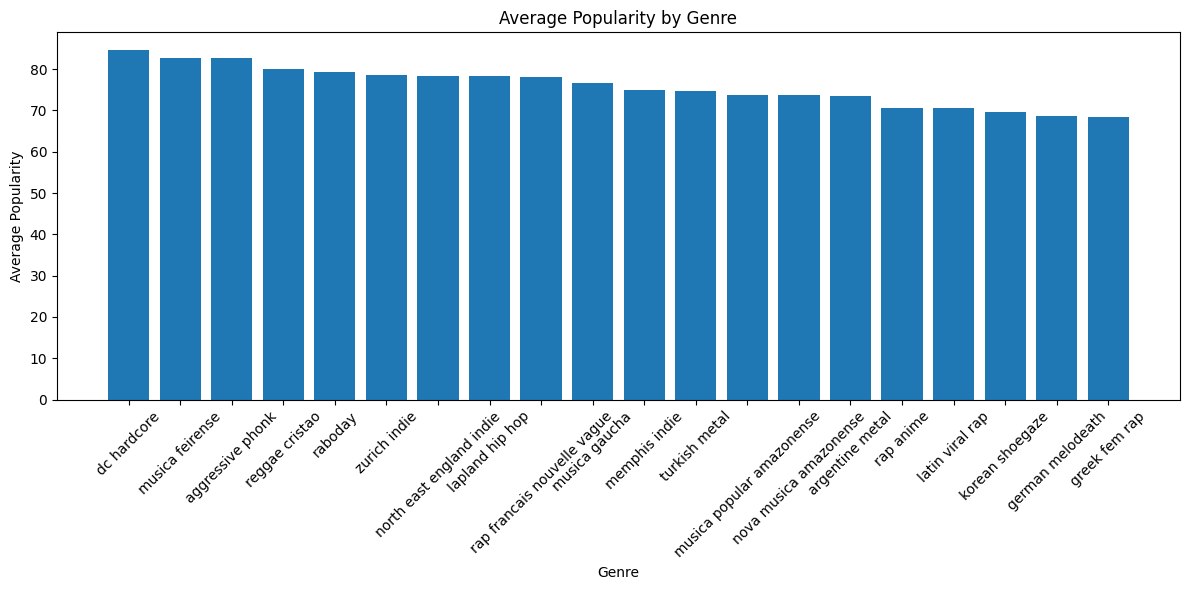

In [108]:
genre_popularity = (
    df_exploded.groupBy("Genre")
    .agg(avg("Popularity").alias("Average Popularity"))
    .orderBy(col("Average Popularity").desc())
)
genre_popularity_pd = genre_popularity.toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(genre_popularity_pd["Genre"].head(20), genre_popularity_pd["Average Popularity"].head(20))
plt.title("Average Popularity by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [152]:
from pyspark.sql.functions import regexp_replace, split, col, explode

filtered_df = filtered_df.withColumn(
    "Artists",
    split(
        regexp_replace(col("Artists"), r"[\[\]'\" ]+", ""), ","
    )
)
df_exploded = filtered_df.withColumn("Artist", explode(col("Artists")))


In [156]:

artist_popularity = (
    df_exploded.groupBy("Artist")
    .agg({"Popularity": "avg"})
    .withColumnRenamed("avg(Popularity)", "Average Popularity")
    .orderBy(col("Average Popularity").desc())
)
artist_popularity.show()


+-------------------+------------------+
|             Artist|Average Popularity|
+-------------------+------------------+
|           Tomatito|              90.0|
|            TigerJK| 88.66666666666667|
|               Arit| 88.66666666666667|
|           SaimBhat| 88.33333333333333|
|         GhettoKids|              88.0|
|      AdanLaAmenaza|              87.5|
|         TannaLeone| 87.33333333333333|
|            Daiko02|              87.0|
|             DjOsar|              87.0|
|            Odetari|              87.0|
|     IskenderPaydas|              87.0|
|          LiamPayne| 86.83333333333333|
|      AnikaNoniRose| 86.66666666666667|
|             AliDee| 86.33333333333333|
|         DiegoMoney| 86.33333333333333|
|              Vedan| 86.33333333333333|
|ArtSchoolGirlfriend| 86.33333333333333|
|            Kreamly| 86.33333333333333|
|            Killemv|              86.0|
|             Sigrid|              86.0|
+-------------------+------------------+
only showing top

In [162]:
from pyspark.sql.functions import avg, count
df_exploded = filtered_df.withColumn("Artist", explode(col("Artists"))) \
                         .withColumn("Genre", explode(split(col("Genres"), ",")))

df_exploded.sample(fraction=0.1, seed=42).limit(1000).select("Artist", "Genre", "Popularity").show(truncate=False)


+------------+---------------------+----------+
|Artist      |Genre                |Popularity|
+------------+---------------------+----------+
|ArianaGrande|['pop']              |0         |
|ArianaGrande|['pop']              |100       |
|ArianaGrande|['pop']              |54        |
|ArianaGrande| 'dance pop']        |0         |
|MariahCarey | 'pop'               |100       |
|TroyeSivan  |['viral pop'         |52        |
|ArianaGrande|['viral pop'         |0         |
|ArianaGrande|['viral pop'         |13        |
|ArianaGrande| 'dance pop'         |54        |
|Brandy      | 'hip pop'           |54        |
|Monica      |['urban contemporary'|54        |
|Brandy      | 'dance pop'         |0         |
|Brandy      | 'pop'               |0         |
|Brandy      | 'hip pop'           |0         |
|Monica      | 'dance pop'         |0         |
|Brandy      | 'contemporary r&b'  |100       |
|Monica      | 'contemporary r&b'  |100       |
|ArianaGrande|['pop']              |62  

In [163]:
artist_genre_popularity = (
    df_exploded.groupBy("Artist", "Genre")
    .agg(
        avg("Popularity").alias("Average Popularity"),
        count("*").alias("Track Count")
    )
    .orderBy(col("Average Popularity").desc())
)

# Show the results
artist_genre_popularity.show()

+--------------------+--------------------+------------------+-----------+
|              Artist|               Genre|Average Popularity|Track Count|
+--------------------+--------------------+------------------+-----------+
|     TheChainsmokers|   ['permanent wave'| 95.16666666666667|         12|
|           ZachBryan|      'country dawn'|              95.0|          6|
|           ZachBryan| 'contemporary co...|              95.0|          6|
|           ZachBryan|['classic texas c...|              95.0|          6|
|         TitoDoubleP|['musica chihuahu...| 94.66666666666667|          6|
|Macklemore&RyanLewis|         'pop dance'| 94.33333333333333|          3|
|          Macklemore|         'pop dance'| 94.33333333333333|          3|
|           RayDalton|  ['seattle hip hop'| 94.33333333333333|          3|
|           RyanLewis|         'pop dance'| 94.33333333333333|          3|
|           RayDalton|          'pop rap']| 94.33333333333333|          3|
|             Lucenzo|  '

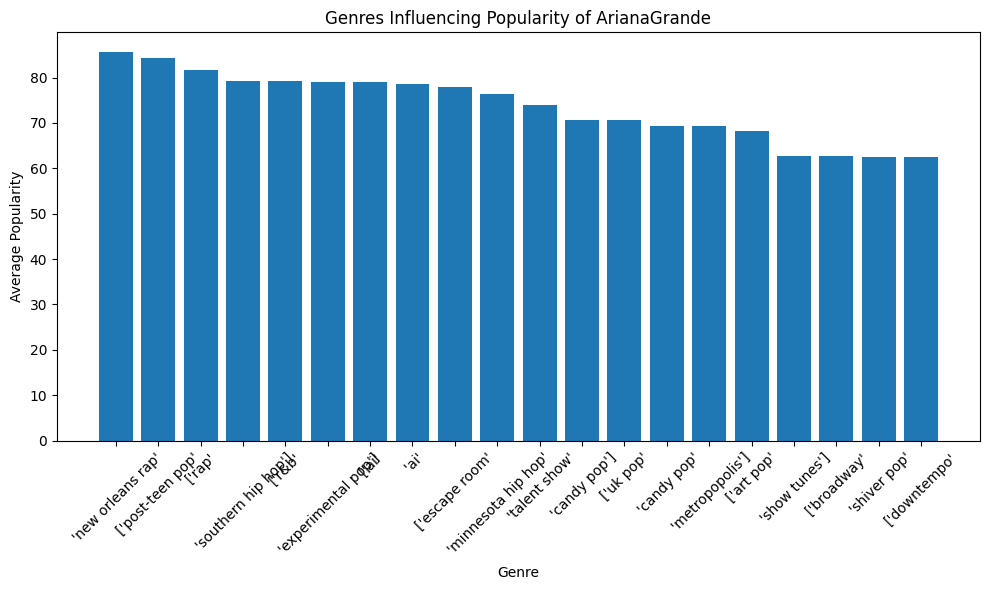

In [171]:
artist_genre_popularity_pd = artist_genre_popularity.toPandas()

# Example: Filter for a specific artist
specific_artist = "ArianaGrande"
artist_genre_subset = artist_genre_popularity_pd[artist_genre_popularity_pd["Artist"] == specific_artist].head(20)

# Plot the popularity of genres for the specific artist
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(artist_genre_subset["Genre"], artist_genre_subset["Average Popularity"])
plt.title(f"Genres Influencing Popularity of {specific_artist}")
plt.xlabel("Genre")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

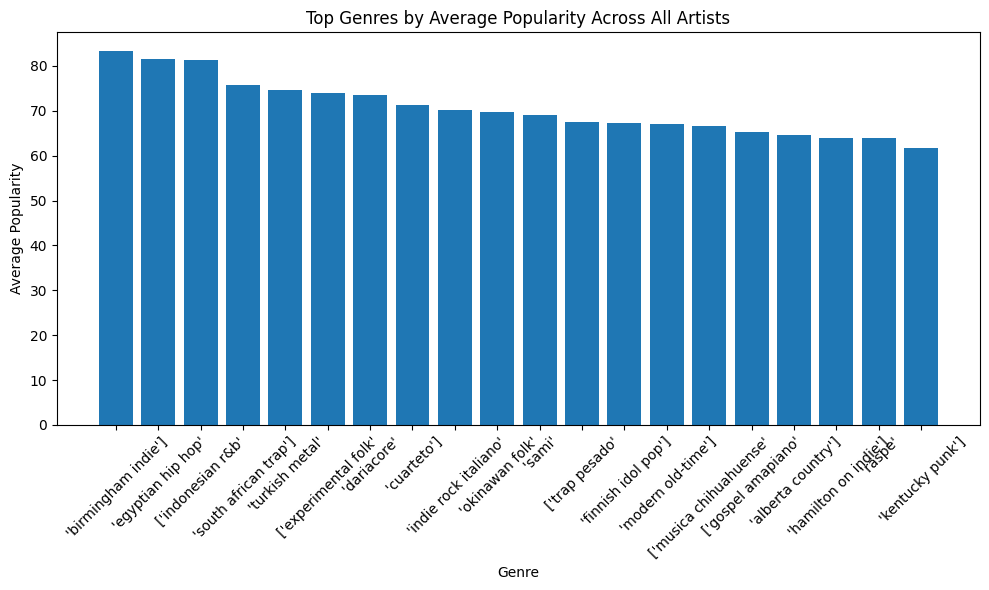

In [169]:
# Group by Genre to find the most influential genres overall
top_genres = (
    artist_genre_popularity.groupBy("Genre")
    .agg(
        avg("Average Popularity").alias("Overall Average Popularity"),
        count("*").alias("Artist Count")
    )
    .orderBy(col("Overall Average Popularity").desc())
)

# Convert to Pandas and visualize
top_genres_pd = top_genres.sample(fraction=0.1, seed=42).limit(20).toPandas()

# Plot top genres by average popularity
plt.figure(figsize=(10, 6))
plt.bar(top_genres_pd["Genre"], top_genres_pd["Overall Average Popularity"])
plt.title("Top Genres by Average Popularity Across All Artists")
plt.xlabel("Genre")
plt.ylabel("Average Popularity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [172]:
genre_artist_popularity = (
    df_exploded.groupBy("Genre", "Artist")
    .agg(
        avg("Popularity").alias("Average Popularity"),
        count("*").alias("Track Count")
    )
    .orderBy("Genre", col("Average Popularity").desc())
)

# Show the top artists per genre
genre_artist_popularity.show()

+--------------------+--------------------+------------------+-----------+
|               Genre|              Artist|Average Popularity|Track Count|
+--------------------+--------------------+------------------+-----------+
| ""Avery's Ambien...|       AverysAmbient|              40.0|          4|
| ""Jane's Addicti...|      JanesAddiction|              40.0|          6|
|   ""Jojo's ASMR""]"|           JojosASMR|              40.0|         29|
|        ""K'NAAN""]"|               KNAAN|              40.0|          6|
|      ""Lil' Kim""]"|              LilKim|              40.0|          1|
| ""Sinéad O'Conno...|       SinéadOConnor|              40.0|          1|
|    ""The J.B.'s""]"|            TheJ.B.s|              40.0|          6|
| ""The Lovin' Spo...|    TheLovinSpoonful|              40.0|          3|
| ""canzone d'auto...|       DavidWhitaker|              30.0|          3|
| ""canzone d'auto...|RoyalPhilharmonic...|              19.5|          6|
| ""canzone d'auto...|   

In [173]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("Genre").orderBy(col("Average Popularity").desc())
top_artists_per_genre = genre_artist_popularity.withColumn("Rank", row_number().over(window_spec))

# Filter for the top N artists per genre
top_artists_per_genre = top_artists_per_genre.filter(col("Rank") <= 3)

# Show the results
top_artists_per_genre.show()


+--------------------+--------------------+------------------+-----------+----+
|               Genre|              Artist|Average Popularity|Track Count|Rank|
+--------------------+--------------------+------------------+-----------+----+
| ""Avery's Ambien...|       AverysAmbient|              40.0|          4|   1|
| ""Jane's Addicti...|      JanesAddiction|              40.0|          6|   1|
|   ""Jojo's ASMR""]"|           JojosASMR|              40.0|         29|   1|
|        ""K'NAAN""]"|               KNAAN|              40.0|          6|   1|
|      ""Lil' Kim""]"|              LilKim|              40.0|          1|   1|
| ""Sinéad O'Conno...|       SinéadOConnor|              40.0|          1|   1|
|    ""The J.B.'s""]"|            TheJ.B.s|              40.0|          6|   1|
| ""The Lovin' Spo...|    TheLovinSpoonful|              40.0|          3|   1|
| ""canzone d'auto...|       DavidWhitaker|              30.0|          3|   1|
| ""canzone d'auto...|RoyalPhilharmonic.